In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

In [2]:
# window
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 내 장치가 GPU 인지 CPU 인지 확인

# mac
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # 내 장치가 GPU 인지 CPU 인지 확인

print(f"지금 실행중인 하드웨어 장치 : {device}")

지금 실행중인 하드웨어 장치 : mps


In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
t = np.linspace(0, 200, 2000, dtype=np.float32)

In [5]:
signal = np.sin(2 * np.pi * 1.0 * t) # 1Hz 사인파
signal += 0.6 * np.sin(2 * np.pi * 3.0 * t) # 3Hz 사인파 진폭이 0.6
signal += 0.3 * np.sin(2 * np.pi * 5.5 * t) # 5.5Hz 사인파 진폭이 0.3

# 저주파로 진폭 변조
amp_mod = 1.0 + 0.4 * np.sin(2 * np.pi * 0.1 * t) # 0.1Hz 사인파
signal += amp_mod

data = signal[:, np.newaxis]  # (2000, 1) shape로 변환
print("Data shape:", data.shape)

Data shape: (2000, 1)


In [6]:
def make_seq(arr, seq_len):
    xs, ys = [], []
    for i in range(len(arr) - seq_len):
		# 시퀀스 길이만큼의 데이터를 x로, 그 다음 값을 y로 설정
        x = arr[i:(i + seq_len)]
        y = arr[i + seq_len]
        xs.append(x)
        ys.append(y)

    return np.stack(xs), np.stack(ys)

X, y = make_seq(data, 100)


In [7]:
tensorX = torch.from_numpy(X)
tensory = torch.from_numpy(y)

dataset = TensorDataset(tensorX, tensory)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [18]:
class SimpleRNN(nn.Module):
	def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
		super(SimpleRNN, self).__init__()

		self.rnn = nn.RNN(
			input_size=input_size, 
			hidden_size=hidden_size, 
			num_layers=num_layers, 
			batch_first=True
		)

		self.lstm = nn.LSTM(
			input_size=input_size, 
			hidden_size=hidden_size, 
			num_layers=num_layers, 
			batch_first=True
		)

		self.gru = nn.GRU(
			input_size=input_size, 
			hidden_size=hidden_size, 
			num_layers=num_layers, 
			batch_first=True
		)
		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x):
		# out, _ = self.rnn(x)
		# out, _ = self.lstm(x)
		out, _ = self.gru(x)
		out = self.fc(out[:, -1])
		return out

In [19]:
model = SimpleRNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [20]:
model.train()
for epoch in range(1, 10):
	bloss = 0.0
	for XX, yy in loader:
		XX, yy = XX.to(device), yy.to(device)  # 데이터 장치로 이동

		optimizer.zero_grad()
		preds = model(XX)
		loss = criterion(preds, yy)
		loss.backward()
		optimizer.step()

		# 손실을 누적
		bloss += loss.item() * XX.size(0)  # 배치 크기를 곱하여 누적
	
	bloss /= len(dataset)  # 전체 데이터셋에 대한 평균 손실
	if epoch % 2 == 0 or epoch == 1:
		# 에폭마다 손실 출력
		print(f'Epoch {epoch}, Loss: {bloss}')

Epoch 1, Loss: 0.4423342093041069
Epoch 2, Loss: 0.10311676114797592
Epoch 4, Loss: 0.03432729778713302
Epoch 6, Loss: 0.02195195044733976
Epoch 8, Loss: 0.011505145709961653


In [21]:
print(X.shape, y.shape)

(1900, 100, 1) (1900, 1)


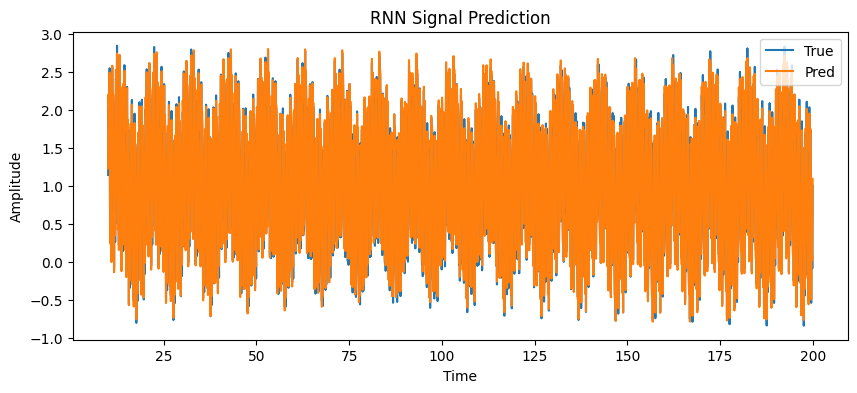

In [22]:
model.eval()
with torch.no_grad():
	X_tensor = torch.from_numpy(X).to(device).float()
	preds = model(X_tensor).cpu().numpy()

plt.figure(figsize=(10, 4))
plt.plot(t[100:], data[100:, 0], label='True')
plt.plot(t[100:], preds[:, 0], label='Pred')
plt.title('RNN Signal Prediction')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()